Objective 1 - Analyze the itemset/rules generation procedure

    From the approaches used in classes make a performance analysis up to a threshold level of support
    Discuss your findings and identify a good candidate method
    Define a good support threshold for analysis according to your computational capabilities


In [1]:
# Modules required
import pandas as pd
import numpy as np
import pickle
from mlxtend.preprocessing import TransactionEncoder
from scipy.sparse import csr_matrix
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth, association_rules
from pyECLAT import ECLAT
import time
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
from pyfim import pyeclat


Data Loading and Preparation

In [4]:
#Read product names and IDs from products.txt in utf-8 format
products = pd.read_csv('products.txt', sep='\t', encoding='utf-8')
products[:5]


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [3]:
# create a dictionary of the products
product_dict = dict(zip(products['product_id'], products['product_name']))

In [5]:
# Open the pickle file and load the order data from pickle file
with open('order_products.pickle', 'rb') as file:
    # Load the order data from the pickle file
    order_products = pickle.load(file) 

In [6]:
# list of list of products in each order
order_products_list = [list(order) for order in order_products.values()]
order_products_list[:2]

[[33120, 28985, 9327, 45918, 30035, 17794, 40141, 1819, 43668],
 [33754, 24838, 17704, 21903, 17668, 46667, 17461, 32665]]

In [7]:
#  transform the order_product_lists into a binary matrix
te = TransactionEncoder()
sparse_matrix = te.fit_transform(order_products_list, sparse=True) 
#17 seconds

In [8]:
# Creating a dataframe from the binary sparse matrix
orders_df = pd.DataFrame.sparse.from_spmatrix(sparse_matrix, columns=te.columns_)
orders_df[:2]

,1,2,3,4,5,6,7,8,9,10,...,49679,49680,49681,49682,49683,49684,49685,49686,49687,49688
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# rename the columns of the dataframe using the product dictionary
orders_df.rename(columns=product_dict, inplace=True) 
orders_df[:10]

,Chocolate Sandwich Cookies,All-Seasons Salt,Robust Golden Unsweetened Oolong Tea,Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce,Green Chile Anytime Sauce,Dry Nose Oil,Pure Coconut Water With Orange,Cut Russet Potatoes Steam N' Mash,Light Strawberry Blueberry Yogurt,Sparkling Orange Juice & Prickly Pear Beverage,...,Famous Chocolate Wafers,All Natural Creamy Caesar Dressing,Spaghetti with Meatballs and Sauce Meal,California Limeade,Cucumber Kirby,"Vodka, Triple Distilled, Twist of Vanilla",En Croute Roast Hazelnut Cranberry,Artisan Baguette,Smartblend Healthy Metabolism Dry Cat Food,Fresh Foaming Cleanser
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# Set a range of support levels to test
support_levels = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Function to generate itemsets and rules using a given method and support level
def generate_itemsets_and_rules(method, support, metrics='lift'):
    start_time = time.time()
    if method == 'apriori':
        itemsets = apriori(orders_df, min_support=support, use_colnames=True)
    elif method == 'fpmax':
        itemsets = fpmax(orders_df, min_support=support, use_colnames=True)
    elif method == 'fpgrowth':
        itemsets = fpgrowth(orders_df, min_support=support, use_colnames=True)
    elif method == 'eclat':
        itemsets = pyeclat(order_products_list, support) # eclat requires a list of lists as input
    rules = association_rules(itemsets, metric=metrics, min_threshold=1, support_only=True)
    end_time = time.time()
    return len(itemsets), len(rules), end_time - start_time

In [31]:
# Generate itemsets and rules using different methods and support levels for comparison
results = []
for method in ['apriori', 'fpmax', 'fpgrowth', 'eclat']:
    for support in support_levels:
        itemsets_count, rules_count, time_elapsed = generate_itemsets_and_rules(method, support)
        results.append((method, support, itemsets_count, rules_count, time_elapsed))

# done with support levels of [0.1, 0.09, 0.08] so far because it takes too long to run with full list of support levels that need to be tested. Will run this later with full support levels
#1.22min

C:\Users\antun\AppData\Roaming\Python\Python311\site-packages\scipy\sparse\_compressed.py:232: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return self.todense() == other
C:\Users\antun\AppData\Roaming\Python\Python311\site-packages\scipy\sparse\_compressed.py:232: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return self.todense() == other


In [33]:
# Create a dataframe from the results
results_df = pd.DataFrame(results, columns=['method', 'support', 'itemsets', 'rules', 'time'])
results_df

# Save the results to a csv file    
results_df.to_csv('Time_Efficiency_Results.csv', index=False)

In [34]:
# print a summary of the results with the time and number of itemsets and rules for each method and support level
results_df.pivot(index='support', columns='method', values=['itemsets', 'rules', 'time'])


itemsets                          rules                       \
method   apriori  eclat fpgrowth  fpmax apriori eclat fpgrowth fpmax   
support                                                                
0.01       102.0  116.0    116.0  106.0     0.0   0.0      0.0   0.0   
0.02        39.0   39.0     39.0   39.0     0.0   0.0      0.0   0.0   
0.04        11.0   11.0     11.0   11.0     0.0   0.0      0.0   0.0   
0.06         5.0    5.0      5.0    5.0     0.0   0.0      0.0   0.0   
0.08         3.0    3.0      3.0    3.0     0.0   0.0      0.0   0.0   
0.10         2.0    2.0      2.0    2.0     0.0   0.0      0.0   0.0   

               time                                   
method      apriori      eclat   fpgrowth      fpmax  
support                                               
0.01     345.830211  62.270925  30.247716  36.312313  
0.02      15.333708  51.638846  16.941574  17.570773  
0.04       2.061912  42.990309  13.073784  13.352869  
0.06       1.272076  44.116050  12.572983  12.405816  
0.08       1.247035  46.626870  11.937796  12.336979  
0.10       1.332869  44.574589  11.619027  13.121828

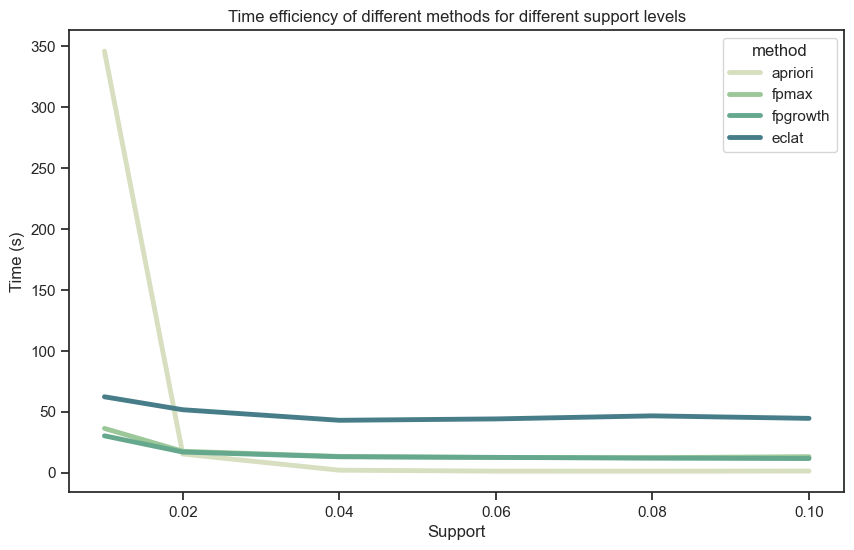

In [35]:
# Plot of how time efficient the different methods are
sns.set_style('ticks')
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 3.5})
plt.figure(figsize=(10, 6))
sns.set_palette(sns.cubehelix_palette(start=.5, rot=-.75)) 
sns.lineplot(x='support', y='time', hue='method', data=results_df)
plt.title('Time efficiency of different methods for different support levels')
plt.xlabel('Support')
plt.ylabel('Time (s)')
plt.savefig('time_efficiency.png')


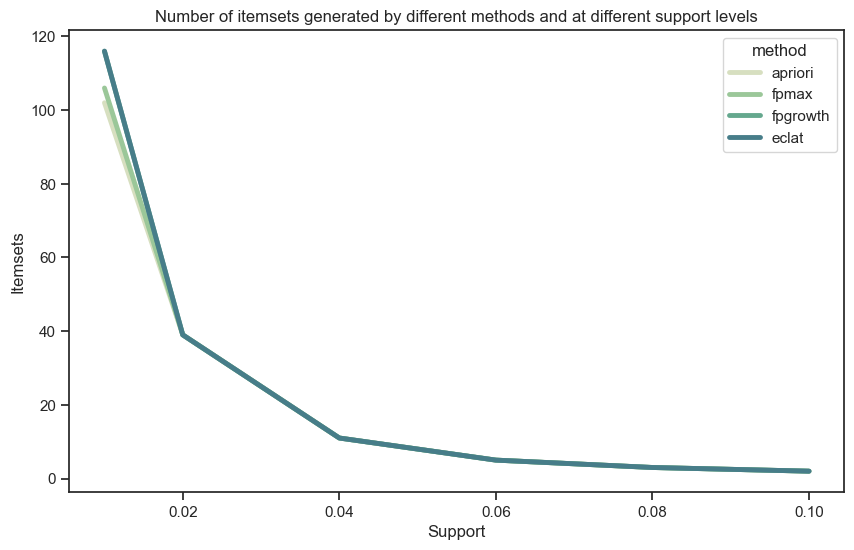

In [20]:
# Plot how many rules are generated by the different methods
sns.set_style('ticks')
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 3.5})
plt.figure(figsize=(10, 6))
sns.set_palette(sns.cubehelix_palette(start=.5, rot=-.75)) 
sns.lineplot(x='support', y='itemsets', hue='method', data=results_df)
plt.title('Number of itemsets generated by different methods and at different support levels')
plt.xlabel('Support')
plt.ylabel('Itemsets')
plt.savefig('Itemsets_efficiency.png')
plt.show()


Summary here of the results: 

From the results so far, we can observe that regarding the algorithms:
- for support above 0.1, the Apriori algorithm is the most efficient. 
- For support below 0.1, the ECLAT algorithm is the most efficient. 

In terms of support, we can observe that:
- we can observe more itemsets the lower the support is.



Objective 2 - Identify the most relevant rules

    From your predefined support level generate all available itemsets and generate rules
    Identify a set of relevant rules and comment them
    Identify the Maximal and Closed Itemsets for the same level of support
    [challenging] Generate the most relevant rules for closed and maximal itemsets with adequate statistics (support, confidence, lift and conviction) and discuss your findings

In [13]:
# Using ECLAT to generate itemsets and rules for support level of 0.01
FI_eclat = pyeclat(order_products_list, 0.01)
FI_eclat

,support,itemsets
0,0.010063,"(40604,)"
1,0.010120,"(19678,)"
2,0.010199,"(21709,)"
3,0.010230,"(20995,)"
4,0.010547,"(33000,)"
...,...,...
111,0.017468,"(21137, 24852)"
112,0.019170,"(21137, 13176)"
113,0.082331,"(21137,)"
114,0.118030,"(13176,)"


In [27]:
def generate_itemsets_and_rules(method, support, metrics='lift'):
    start_time = time.time()
    if method == 'apriori':
        itemsets = apriori(orders_df, min_support=support, use_colnames=True)
    elif method == 'fpmax':
        itemsets = fpmax(orders_df, min_support=support, use_colnames=True)
    elif method == 'fpgrowth':
        itemsets = fpgrowth(orders_df, min_support=support, use_colnames=True)
    elif method == 'eclat':
        itemsets = pyeclat(order_products_list, support) # eclat requires a list of lists as input
    rules = association_rules(itemsets, metric=metrics, min_threshold=2, support_only=True)
    end_time = time.time()
    return len(itemsets), len(rules), end_time - start_time

In [28]:
# ECLAT with 0.02 support level and different metrics
support = 0.02
method = 'eclat'

# Function to generate itemsets and rules using a given method and support level
metrics = ['lift', 'confidence', 'conviction', 'leverage', 'support']
results = []
for metric in metrics:
    itemsets_count, rules_count, time_elapsed = generate_itemsets_and_rules(method, support, metric)
    results.append((method, metric, support, itemsets_count, rules_count, time_elapsed))

In [29]:
# PLot of how many rules are generated by the different metrics
results_df = pd.DataFrame(results, columns=['method', 'metric', 'support', 'itemsets', 'rules', 'time'])
results_df.pivot(index='metric', columns='method', values=['itemsets', 'rules', 'time'])

,itemsets,rules,time
method,eclat,eclat,eclat
metric,,,
confidence,39.0,0.0,50.274234
conviction,39.0,0.0,49.741458
leverage,39.0,0.0,48.714748
lift,39.0,0.0,50.499184
support,39.0,0.0,52.183218


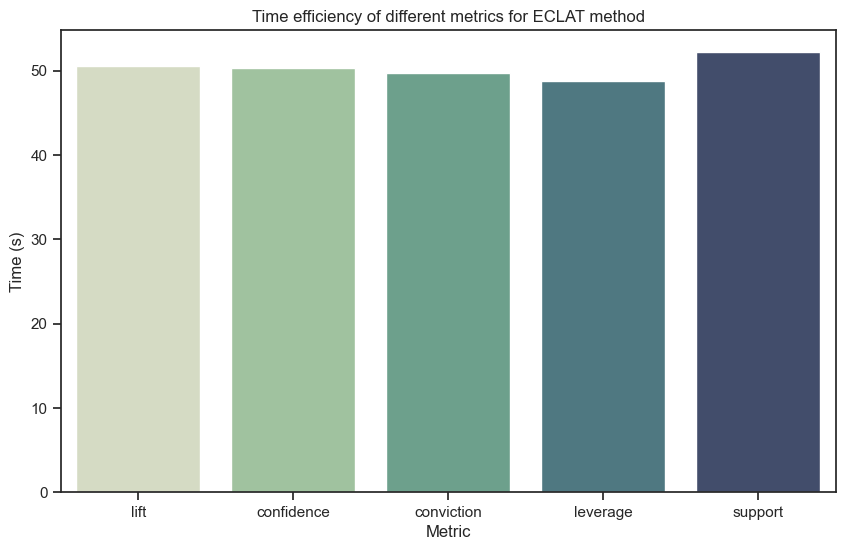

In [30]:
# Visualisation of efficiency of different metrics for ECLAT method
sns.set_style('ticks')
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 3.5})
plt.figure(figsize=(10, 6))
sns.set_palette(sns.cubehelix_palette(start=.5, rot=-.75))
sns.barplot(x='metric', y='time', data=results_df)
plt.title('Time efficiency of different metrics for ECLAT method')
plt.xlabel('Metric')
plt.ylabel('Time (s)')
plt.savefig('time_efficiency_metrics.png')
plt.show()

